In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
#from xgboost import predict_proba
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error  
import xgboost as xgb
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import train_test_split                 
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch.utils.data as Data
from sklearn import preprocessing

In [3]:
m = loadmat("PPMI.mat") 

m.keys()
print(m.keys())
print(m['NC'].shape)
print(m['PD'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'NC', 'PD'])
(169, 294)
(374, 294)


In [4]:
PD = m['PD']
NC = m['NC']

PD = pd.DataFrame(PD)
NC = pd.DataFrame(NC)

PD['label'] = [0]*374
NC['label'] = [1]*169

df = PD.append(NC)
label = df['label']

df=df.drop(['label'],axis = 1)
PD=PD.drop(['label'],axis = 1)
NC=NC.drop(['label'],axis = 1)

In [5]:
df = pd.DataFrame(df)
df = df*1.0
x_train,x_test,y_train,y_test = train_test_split(df , label, test_size = 0.1 )

In [6]:
other_params = {'learning_rate': 0.1, 'n_estimators':10, 'max_depth': 1, 'min_child_weight': 6, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 0.01, 'reg_alpha': 0.05, 'reg_lambda': 0.5}
model=xgb.XGBClassifier(**other_params,eval_metric=['logloss','auc','error'])
#train = [x_train, y_train]
eval = [x_test, y_test]
clf = model.fit(x_train, y_train,eval_set=[eval])
pre_train = clf.predict(x_train)
pre_test = clf.predict(x_test)
accuracy_test = accuracy_score(y_test, pre_test)
accuracy_train = accuracy_score(y_train, pre_train)
print("Accuracy_test: %.2f%%" % (accuracy_test * 100.0))
print("Accuracy_train: %.2f%%" % (accuracy_train * 100.0))

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68455	validation_0-auc:0.44664	validation_0-error:0.34546
[1]	validation_0-logloss:0.67287	validation_0-auc:0.50000	validation_0-error:0.34546
[2]	validation_0-logloss:0.66839	validation_0-auc:0.50000	validation_0-error:0.34546
[3]	validation_0-logloss:0.66129	validation_0-auc:0.52047	validation_0-error:0.34546
[4]	validation_0-logloss:0.65562	validation_0-auc:0.53290	validation_0-error:0.34546
[5]	validation_0-logloss:0.65023	validation_0-auc:0.54751	validation_0-error:0.34546
[6]	validation_0-logloss:0.64467	validation_0-auc:0.59357	validation_0-error:0.34546
[7]	validation_0-logloss:0.64664	validation_0-auc:0.53363	validation_0-error:0.34546
[8]	validation_0-logloss:0.64413	validation_0-auc:0.53509	validation_0-error:0.32727
[9]	validation_0-logloss:0.64117	validation_0-auc:0.54825	validation_0-error:0.32727
Accuracy_test: 67.27%
Accuracy_train: 70.49%


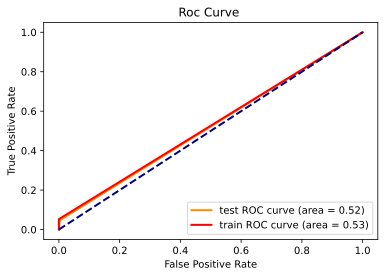

In [7]:
#ROC曲线
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
%config InlineBackend.figure_format = 'svg'
import warnings
def draw_roc_curve(train_pre_proba, test_pre_proba, train_auc, test_auc, model_name):
    fpr, tpr, roc_auc = train_pre_proba
    test_fpr, test_tpr, test_roc_auc = test_pre_proba
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='test ROC curve (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='red',
             lw=lw, label='train ROC curve (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc Curve ')
    plt.legend(loc="lower right")
    plt.savefig("Roc1 Curve",dpi=500,  bbox_inches='tight')
    plt.show()
    
    
y_train_pred = clf.predict_proba(x_train)[:, 1]
y_test_pred =clf.predict_proba(x_test)[:, 1]

train_roc = roc_curve(y_train, clf.predict(x_train))
test_roc = roc_curve(y_test, clf.predict(x_test))

train_auc = roc_auc_score(y_train, clf.predict(x_train))
test_auc = roc_auc_score(y_test, clf.predict(x_test))

draw_roc_curve(train_roc, test_roc, train_auc, test_auc, 'name')

In [19]:
# 使用交叉验证
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix
from sklearn.model_selection import KFold
other_params = {'learning_rate': 0.1, 'n_estimators':20, 'max_depth': 1, 'min_child_weight': 6, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 0.01, 'reg_alpha': 0.05, 'reg_lambda': 30}
#x_train,x_test,y_train,y_test = train_test_split(df, label, test_size = 0.1)  
train = df
label = label
accuracy = [] 
train_accuracy = []
roc = []
sensitivity = []
specificity = []
k = 10
for i in range(k):
    kfold = KFold(n_splits=50,shuffle = True)
    accurcies = []
    for train_index, test_index in kfold.split(train, label):
        # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
        this_train_x, this_train_y = train.iloc[train_index], label.iloc[train_index]  # 本组训练集
        this_test_x, this_test_y = train.iloc[test_index], label.iloc[test_index]  # 本组验证集
        #print(test_index)
        #print('this test y',np.array(this_test_y))
        # 训练本组的数据，并计算准确率
        model=xgb.XGBClassifier(**other_params,eval_metric=['logloss','auc','error'])
        #model=RandomForestClassifier(random_state=0,n_estimators=100,max_features=1)
        model.fit(this_train_x, this_train_y)
        prediction = model.predict(this_test_x)
        
        if(len(set(this_test_y))!=1):
            pred = prediction
            roc.append(roc_auc_score(np.array(this_test_y), np.array(pred)))
            sensitivity.append(confusion_matrix(this_test_y, pred)[0][0]/(confusion_matrix(this_test_y, pred)[0][0]+confusion_matrix(this_test_y, pred)[0][1]))
            specificity.append(confusion_matrix(this_test_y, pred)[1][1]/(confusion_matrix(this_test_y, pred)[1][1]+confusion_matrix(this_test_y, pred)[1][0]))
        else:
            roc.append(0)
            sensitivity.append(0)
            specificity.append(0)
        #print('pred',np.array(prediction))
        #print(np.array(this_test_y))
        #print(np.array(prediction))
        accurcies.append(accuracy_score(this_test_y, prediction))
        accuracy.append(accuracy_score(this_test_y, prediction))
        train_accuracy.append(accuracy_score(this_train_y, model.predict(this_train_x)))
    print('第 %d 轮交叉验证平均准确率为' %(i),np.array(accurcies).mean())  # 得到预测结果区间[0,1]
print('平均测试集准确率为：',np.array(accuracy)[np.nonzero(np.array(accuracy))].mean())
print('平均训练集准确率为：',np.array(train_accuracy)[np.nonzero(np.array(train_accuracy))].mean())
print('平均roc为：',np.array(roc)[np.nonzero(np.array(roc))].mean())
print('平均sensitivity为：',np.array(sensitivity)[np.nonzero(np.array(sensitivity))].mean())
print('平均specificity为：',np.array(specificity)[np.nonzero(np.array(specificity))].mean())

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 0 轮交叉验证平均准确率为 0.6914545454545454


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 1 轮交叉验证平均准确率为 0.6876363636363638


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 2 轮交叉验证平均准确率为 0.6943636363636364


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 3 轮交叉验证平均准确率为 0.6929090909090909


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 4 轮交叉验证平均准确率为 0.6865454545454545


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 5 轮交叉验证平均准确率为 0.6941818181818182


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 6 轮交叉验证平均准确率为 0.6934545454545455


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 7 轮交叉验证平均准确率为 0.6932727272727272


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 8 轮交叉验证平均准确率为 0.6914545454545454


C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12588\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of 

第 9 轮交叉验证平均准确率为 0.6925454545454545
平均测试集准确率为： 0.6917818181818182
平均训练集准确率为： 0.6975868117761571
平均roc为： 0.5070575922154333
平均sensitivity为： 0.9977685643164259
平均specificity为： 0.321047619047619


In [18]:
print('平均准确率为：',np.array(accuracy)[np.nonzero(np.array(accuracy))].mean())
print('平均roc为：',np.array(roc)[np.nonzero(np.array(roc))].mean())
print('平均sensitivity为：',np.array(sensitivity)[np.nonzero(np.array(sensitivity))].mean())
print('平均specificity为：',np.array(specificity)[np.nonzero(np.array(specificity))].mean())

平均准确率为： 0.6907636363636364
平均roc为： 0.504420731707317
平均sensitivity为： 0.9970141308555943
平均specificity为： 0.2530020703933747
